## Text Analysis using BERT to classify Myers Briggs Personality Type using social media posts and extrapolate how the personality indicators affects driving behaviour

### Including imports

In [2]:
import pandas as pd
import numpy as np
import regex as re
import string as st

# visualization imports
import matplotlib.pyplot as plt
from IPython.display import Image

#splitting into 70 30
from sklearn.model_selection import train_test_split

#BERT
import tensorflow as tf
import transformers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input
from transformers import BertTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm

In [2]:
data = pd.read_csv("mbti_1.csv")

### Data Cleaning

In [3]:
### Cleaning data to remove url and symbols. The pipe is used to separate posts so will be replaced with spaces
data.posts

0       'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1       'I'm finding the lack of me in these posts ver...
2       'Good one  _____   https://www.youtube.com/wat...
3       'Dear INTP,   I enjoyed our conversation the o...
4       'You're fired.|||That's another silly misconce...
                              ...                        
8670    'https://www.youtube.com/watch?v=t8edHB_h908||...
8671    'So...if this thread already exists someplace ...
8672    'So many questions when i do these things.  I ...
8673    'I am very conflicted right now when it comes ...
8674    'It has been too long since I have been on per...
Name: posts, Length: 8675, dtype: object

In [4]:
def cleaningPosts(data):
    cleanPosts = []
    for post in data.posts:
        post = post.lower()
        post = re.sub('(https|http):\/\/[0-9a-zA-Z\.\-]+\.[a-zA-Z]{1,5}(\/\S*)?', ' ', post)
        post = re.sub('[^0-9a-zA-Z]', ' ', post)   
        cleanPosts.append(post)
    return cleanPosts

In [5]:
data.posts = cleaningPosts(data)

### Data Preview

### 16 Personality Types in this Dataset

In [6]:
data

,type,posts
0,INFJ,and intj moments sportscenter not top t...
1,ENTP,i m finding the lack of me in these posts ver...
2,INTP,good one course to which i say i ...
3,INTJ,dear intp i enjoyed our conversation the o...
4,ENTJ,you re fired that s another silly misconce...
...,...,...
8670,ISFP,just because i always think of cats as fi d...
8671,ENFP,so if this thread already exists someplace ...
8672,INTP,so many questions when i do these things i ...
8673,INFP,i am very conflicted right now when it comes ...


### The number of posts classified based on the personality type

In [7]:
### The data is not as balanced therefore there might be some bias

data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

### Preparation for training

In [34]:
#splitting
trainData, testData = train_test_split(data, random_state = 0, test_size=0.3)

In [9]:
### using Tokenizer

def tokenizing(posts, tokenizer, maxLen = 150):
    allTokens = []
    for post in tqdm(posts):
        token = tokenizer.encode(post, add_special_tokens=True, max_length = maxLen)
        allTokens.append(token)
    return allTokens
        

In [10]:
def create_model(bertLayer, maxLen = 150):
    input_word_ids = Input(shape=(maxLen,), dtype=tf.int32, name="input_word_ids")
    bertOutput = bertLayer(input_word_ids)[0]
    output = Dense(16, activation='softmax')(bertLayer(input_word_ids)[0][:,0,:])
    model = Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.000002), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
trainInputs = tokenizing(trainData['posts'], tokenizer)
trainInputs = pad_sequences(trainInputs, maxlen=150, dtype="long", truncating='post', padding = 'post')
testInputs = tokenizing(testData['posts'], tokenizer)
testInputs = pad_sequences(testInputs, maxlen=150, dtype="long", truncating='post', padding = 'post')

  0%|          | 0/6072 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


  0%|          | 0/2603 [00:00<?, ?it/s]

In [12]:
types = np.unique(data.type.values)

def get_type_index(string):
    return list(types).index(string)

In [13]:
trainData['type_index'] = data['type'].apply(get_type_index)
trainData

,type,posts,type_index
3162,INFP,nvm are you good at helping other people s...,9
320,ENTP,well sorry but i just think this is another...,3
6248,INFJ,lol hahaha first of all stop address...,8
2843,ENTP,i thought personality cafe had a rate my pic ...,3
5281,INFP,same problem here i cant get onto my origina...,9
...,...,...,...
4373,INFP,hey it seems like you have a great foundatio...,9
7891,INFJ,dear istj mother when i started my very fi...,8
4859,INTP,oh entjs how can you be scary and exciting a...,11
3264,ENFJ,hi entp and welcome to the forum wink f...,0


### Building the model

In [14]:
bertLayer= transformers.TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
model = create_model(bertLayer, maxLen = 150)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 150)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  335141888
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             150, 1024),                         
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [16]:
one_hot_labels = tf.keras.utils.to_categorical(trainData.type_index.values, num_classes=16)

In [17]:
model.fit(
np.array(trainInputs), one_hot_labels, verbose=1, epochs = 20, batch_size=2, callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5)])

Epoch 1/20
3036/3036 [==============================] - 607s 194ms/step - loss: 2.3090 - accuracy: 0.2139
Epoch 2/20
3036/3036 [==============================] - 586s 193ms/step - loss: 2.0331 - accuracy: 0.3340
Epoch 3/20
3036/3036 [==============================] - 585s 193ms/step - loss: 1.8259 - accuracy: 0.4262
Epoch 4/20
3036/3036 [==============================] - 2705s 891ms/step - loss: 1.6585 - accuracy: 0.4802
Epoch 5/20
3036/3036 [==============================] - 592s 195ms/step - loss: 1.4952 - accuracy: 0.5283
Epoch 6/20
3036/3036 [==============================] - 592s 195ms/step - loss: 1.3013 - accuracy: 0.5947
Epoch 7/20
3036/3036 [==============================] - 592s 195ms/step - loss: 1.1043 - accuracy: 0.6621
Epoch 8/20
3036/3036 [==============================] - 591s 195ms/step - loss: 0.9315 - accuracy: 0.7156
Epoch 9/20
3036/3036 [==============================] - 590s 194ms/step - loss: 0.7436 - accuracy: 0.7777
Epoch 10/20
3036/3036 [======================

### Evaluating the model

In [21]:
testData['type_index'] = data['type'].apply(get_type_index)
testData

,type,posts,type_index
4587,ISFP,dear isfj mother i wish you were less of a w...,13
2786,INFJ,to me i think you guys may be over analyzing...,8
2813,ENFP,nihm while nihm has her intj husband i ve go...,1
3705,INTP,i want 5 kids an astro nuclear theoretical...,11
5957,ISFP,i have the same thing as well i ve noticed t...,13
...,...,...,...
2346,INTP,yikes when i wall posted you i hadn t read...,11
1814,ISFJ,i like eggs i m sure there is at least prim...,12
7695,INFJ,i totally understand i m also strange and th...,8
3769,INTP,do you have money to have someone else do the...,11


In [24]:
testLabels = tf.keras.utils.to_categorical(testData.type_index.values, num_classes=16)

In [36]:
testInputs

array([[  101,  6203,  2003, ...,  5870,  5292,   102],
       [  101,  2000,  2033, ...,  5743,  2090,   102],
       [  101,  9152, 14227, ...,  1996,  2028,   102],
       ...,
       [  101,  1045,  6135, ...,  2021,  2008,   102],
       [  101,  2079,  2017, ...,  2031,  2412,   102],
       [  101,  1045,  2222, ...,  2060,  2711,   102]])

In [39]:
### Result isnt too great due to the unbalanced dataset
model.evaluate(np.array(testInputs), testLabels)

82/82 [==============================] - 31s 376ms/step - loss: 3.7988 - accuracy: 0.3976


[3.7987935543060303, 0.3976181447505951]

### Implementation of the BERT analysis

In [111]:
def textToPersonalityAnalysis(sentence):
    cols = data['type'].unique()
    cols = types.tolist()
    colnames = ['sentence']
    colnames = colnames+cols
    personalityPrediction = pd.DataFrame(columns = colnames)
    personalityPrediction.loc[0, 'sentence'] = sentence
    sentence = tokenizing(personalityPrediction['sentence'], tokenizer, 150)
    sentence = pad_sequences(sentence, maxlen=150, dtype="long", value=0, truncating="post", padding="post")
    prediction = model.predict(np.array(sentence))
    personalityPrediction.loc[0, cols] = prediction
    return personalityPrediction

In [113]:
### in an ideal situation social media text will be provided into the function and will be analysed
df = textToPersonalityAnalysis('Dear .What your purpose of many loading bay at your area? Which is your are not alllow riders delivery to park around your loading bay. Commonly riders know your centralize parking which forcing us and vendors to put those orders at Eat Place.')
df

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 283ms/step


,sentence,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
0,Dear .What your purpose of many loading bay at...,0.055594,0.019875,0.010179,0.000157,0.01647,0.004389,0.008437,0.000635,0.03332,0.139005,0.03452,0.296704,0.001955,0.284419,0.08805,0.006292


In [114]:
df. drop("sentence", axis=1, inplace=True)

,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
0,0.055594,0.019875,0.010179,0.000157,0.01647,0.004389,0.008437,0.000635,0.03332,0.139005,0.03452,0.296704,0.001955,0.284419,0.08805,0.006292


In [128]:
radarDf= pd.DataFrame({'Personality Types': df.columns,
                   'Tendency': df.iloc[0].values})
radarDf

,Personality Types,Tendency
0,ENFJ,0.055594
1,ENFP,0.019875
2,ENTJ,0.010179
3,ENTP,0.000157
4,ESFJ,0.01647
5,ESFP,0.004389
6,ESTJ,0.008437
7,ESTP,0.000635
8,INFJ,0.03332
9,INFP,0.139005


In [129]:
import plotly.express as px
import time
fig = px.line_polar(radarDf, r='Tendency', theta='Personality Types', line_close=True)
### an example of user's name to identify
fig.update_layout(title_text = 'User1 Personality Tendency')
radarDf
fig.show()

C:\Users\User\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



User 1 Personality Tendency


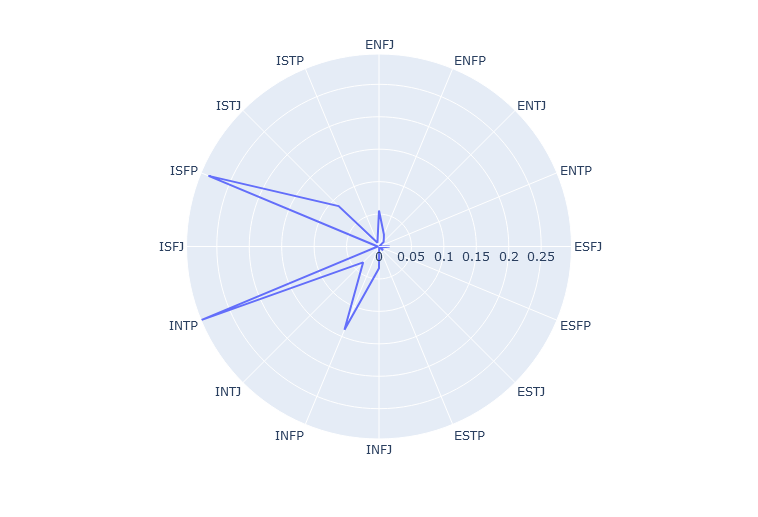

In [5]:
### Theres a bug with plotly in which the graph has to be generated everytimme the note book is open. 
### This is a screenshot of the radar graph based on theb data aboe
print('User 1 Personality Tendency')
Image(filename='radar_graph.png') 

In [7]:
## The personality type obtained from the data will relate to this table to show their driving behaviors results
pd.set_option('display.max_colwidth', None)
outcome = pd.read_csv("MBTIoutcome.csv")
outcome

,Personality Type,Energy and Attention (E or I),Take In Information (S or N),Decision Making (T or F),Orient to the Outer World (J or P)
0,ENFJ,*Better on-road driving performance\n*Heightened attention to environmental cues\n*Less driving errors,*More difficulty in driving behaviors\n*Not bound by facts and tend to see possibilities including negative situations\n*Lower self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome,*Good performance during the on-road tests\n*Committed more vehicle positioning errors
1,ENFP,*Better on-road driving performance\n*Heightened attention to environmental cues\n*Less driving errors,*More difficulty in driving behaviors\n*Not bound by facts and tend to see possibilities including negative situations\n*Lower self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome,*Poor performance during the on-road tests\n*Committed more vehicle positioning errors
2,ENTJ,*Better on-road driving performance\n*Heightened attention to environmental cues\n*Less driving errors,*More difficulty in driving behaviors\n*Not bound by facts and tend to see possibilities including negative situations\n*Lower self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome,*Good performance during the on-road tests\n*Committed more vehicle positioning errors
3,ENTP,*Better on-road driving performance\n*Heightened attention to environmental cues\n*Less driving errors,*More difficulty in driving behaviors\n*Not bound by facts and tend to see possibilities including negative situations\n*Lower self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome,*Poor performance during the on-road tests\n*Committed more vehicle positioning errors
4,ESFJ,*Better on-road driving performance\n*Heightened attention to environmental cues\n*Less driving errors,*Less difficulty in driving behaviors\n*Take information in via observable facts and evidence like their crash-free driving record\n*Higher self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome,*Good performance during the on-road tests\n*Committed more vehicle positioning errors
5,ESFP,*Better on-road driving performance\n*Heightened attention to environmental cues\n*Less driving errors,*Less difficulty in driving behaviors\n*Take information in via observable facts and evidence like their crash-free driving record\n*Higher self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome,*Poor performance during the on-road tests\n*Committed more vehicle positioning errors
6,ESTJ,*Better on-road driving performance\n*Heightened attention to environmental cues\n*Less driving errors,*Less difficulty in driving behaviors\n*Take information in via observable facts and evidence like their crash-free driving record\n*Higher self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome,*Good performance during the on-road tests\n*Committed more vehicle positioning errors
7,ESTP,*Better on-road driving performance\n*Heightened attention to environmental cues\n*Less driving errors,*Less difficulty in driving behaviors\n*Take information in via observable facts and evidence like their crash-free driving record\n*Higher self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome,*Poor performance during the on-road tests\n*Committed more vehicle positioning errors
8,INFJ,*Poor on-road driving performance\n*Pay less attention to the environment\n*Prone to more driving errors,*More difficulty in driving behaviors\n*Not bound by facts and tend to see possibilities including negative situations\n*Lower self-rated ability to perform driving-related behaviors,*Not significantly correlated to any driving outcome

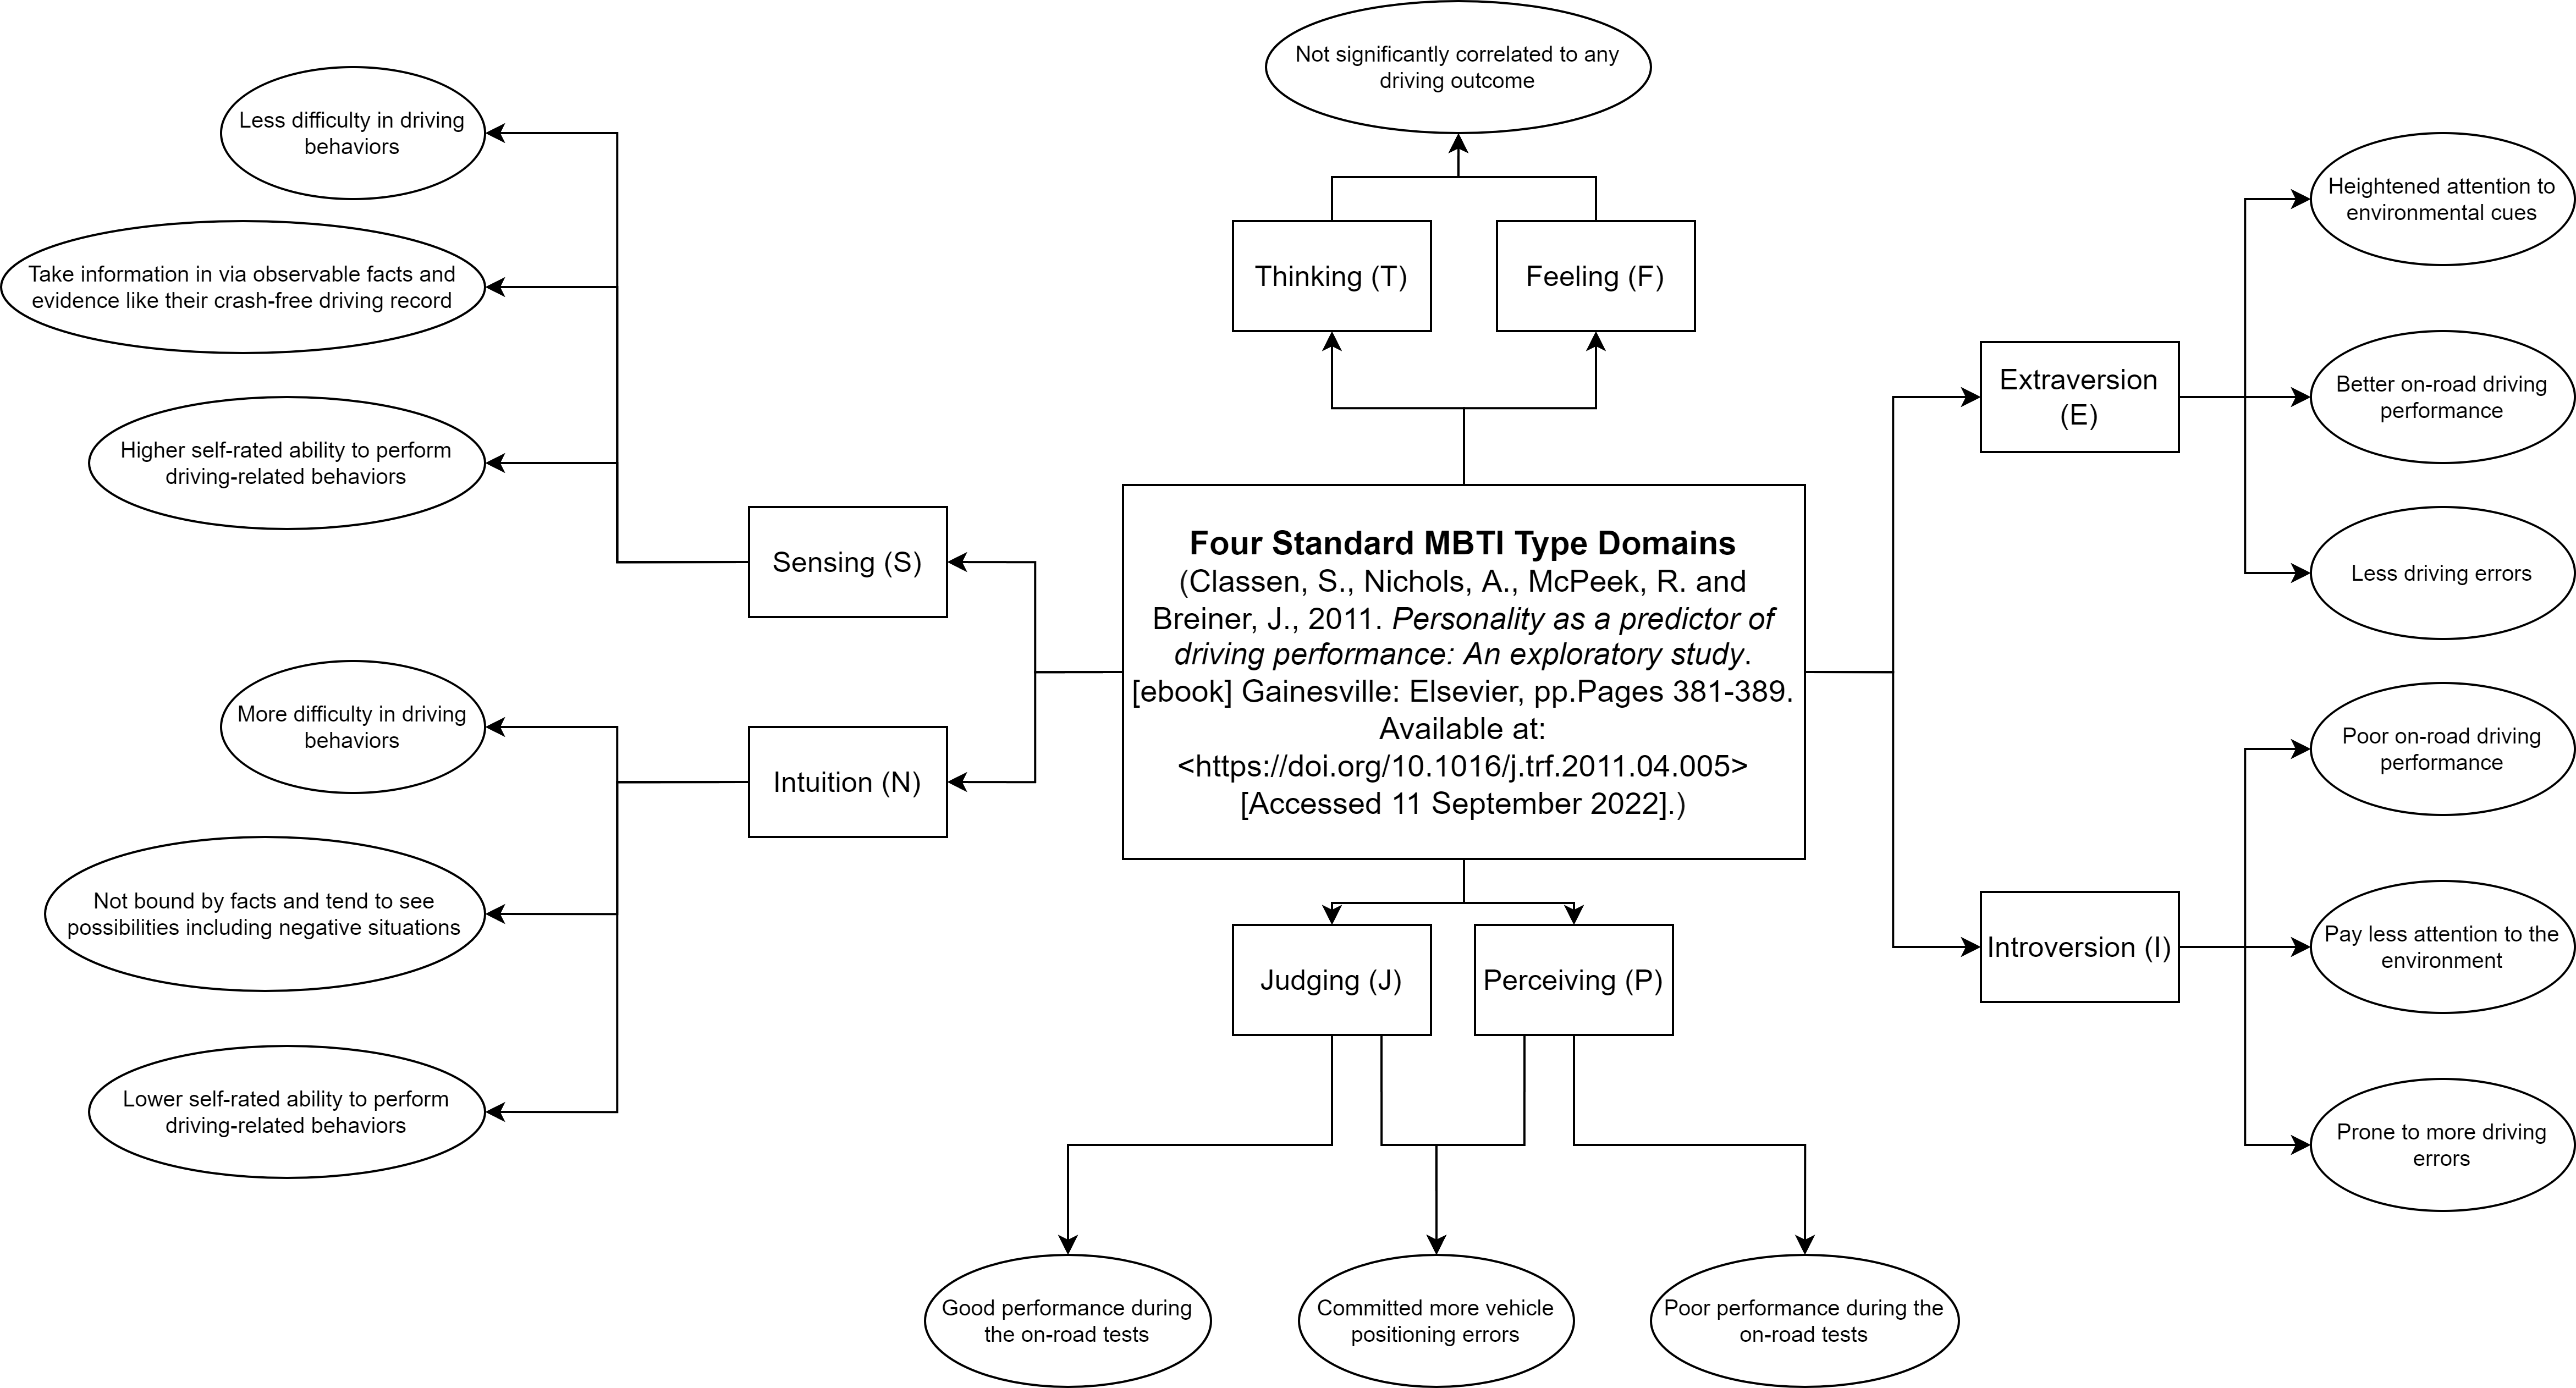

In [11]:
## The four standard MBTI Type Domains to refer on the driving behaviours
Image(filename='MBTI_mapping.png') 

### Reference

Kaggle.com. 2015. MBTI_Prediction. [online] Available at: <https://www.kaggle.com/code/sarthak1799/mbti-prediction/data> [Accessed 11 September 2022].

Classen, S., Nichols, A., McPeek, R. and Breiner, J., 2011. Personality as a predictor of driving performance: An exploratory study. [ebook] Gainesville: Elsevier, pp.Pages 381-389. Available at: <https://doi.org/10.1016/j.trf.2011.04.005> [Accessed 11 September 2022].

Analytics Vidhya. 2021. Twitter Sentiment Analysis - A NLB Use-Case for Beginners. [online] Available at: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/ [Accessed 11 September 2022].

GitHub. 2021. Sentiment Analysis of South African Banks PCO. [online] Available at: https://github.com/Slyth3/Sentiment-analysis-of-South-African-Banks-POC/blob/main/Twint_SentimentAnalysis.ipynb [Accessed 11 September 2022].